In [1]:
!pip install git+https://github.com/ElArkk/jax-unirep.git --upgrade
!pip install optuna
!pip install biopython
!pip install seaborn

  Cloning https://github.com/ElArkk/jax-unirep.git to /tmp/pip-req-build-juafkd7x
  Running command git clone -q https://github.com/ElArkk/jax-unirep.git /tmp/pip-req-build-juafkd7x
  Created wheel for jax-unirep: filename=jax_unirep-0.1-cp36-none-any.whl size=67744670 sha256=6f22c74aab2232213b5ebf62569376893b87bf88620843205c0fdb2d56a4345d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_wsgvign/wheels/08/4d/ac/6e75862c118d1ad82122f410859524b20190ce7a821b76ffcd
Successfully built jax-unirep
  Found existing installation: jax-unirep 0.1
    Uninstalling jax-unirep-0.1:
      Successfully uninstalled jax-unirep-0.1


In [2]:
from jax_unirep import get_reps, fit
from jax_unirep.utils import load_params_1900
from Bio import SeqIO
import pandas as pd
import glob
import os
from pathlib import Path
import numpy as np

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import RidgeCV, LinearRegression, HuberRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore') 

from sklearn.preprocessing import normalize, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import feather
import random

from google.colab import drive

drive.mount('/content/drive/')
gdrive_path = "/content/drive/My Drive/Colab Notebooks/UniRep/"
!ls "/content/drive/My Drive/Colab Notebooks/UniRep"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 2MS2_data_exploration_2.ipynb	 inputs
 2MS2_data_exploration.ipynb	 MS2_double_AA_additive_fitness.txt
 2MS2_weights			 MS2_double_AA_heat_fitness.txt
 BLAC_data_exploration.ipynb	 MS2_double_AA_mut_fitness.txt
 blac_fitness.txt		 MS2_double_AA_mut_seqs.txt
 blac_seqs.txt			 MS2_single_AA_mut_fitness.txt
 BLAC_weights			 MS2_single_AA_mut_seqs.txt
 DE_notebook.ipynb		'old numpy files'
 DE_records			 PETase_data_exploration.ipynb
 double_mut_data.pkl		 PETase_mutant_fitness.txt
 Epistasis_notebook.ipynb	 PETase_mutant_seqs.txt
 feathers			 PETase_weights


In [0]:
# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open(gdrive_path + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data

# read sequence text file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_labeled_data(name):
    seqs = np.loadtxt(gdrive_path + name + '_seqs.txt', dtype='str')
    
    fitnesses = np.loadtxt(gdrive_path + name + '_fitness.txt')
    data = []
    for seq, fitness in zip(seqs, fitnesses):
        data.append([str(seq).strip(), fitness])
    
    return data

# save represented dataframe of features as feather
def save_reps(df, path):
  feather.write_dataframe(df, path + '.feather')
  print(path + '.feather', 'saved!')


# read represented dataframe of features as feather
def read_reps(path):
  return feather.read_dataframe(path + '.feather')


aa_to_int = {
  'M':1,
  'R':2,
  'H':3,
  'K':4,
  'D':5,
  'E':6,
  'S':7,
  'T':8,
  'N':9,
  'Q':10,
  'C':11,
  'U':12,
  'G':13,
  'P':14,
  'A':15,
  'V':16,
  'I':17,
  'F':18,
  'Y':19,
  'W':20,
  'L':21,
  'O':22, #Pyrrolysine
  'X':23, # Unknown
  'Z':23, # Glutamic acid or GLutamine
  'B':23, # Asparagine or aspartic acid
  'J':23, # Leucine or isoleucine
  'start':24,
  'stop':25,
}


def get_int_to_aa():
  return {value:key for key, value in aa_to_int.items()}


def _one_hot(x, k, dtype=np.float32):
  return np.array(x[:, None] == np.arange(k))


def aa_seq_to_int(s):
  """Return the int sequence as a list for a given string of amino acids."""
  # Make sure only valid aa's are passed
  if not set(s).issubset(set(aa_to_int.keys())):
    raise ValueError(
      f"Unsupported character(s) in sequence found:"
      f" {set(s).difference(set(aa_to_int.keys()))}"
    )

  return [aa_to_int[a] for a in s]


def aa_seq_to_onehot(seq):
  return 1*np.equal(np.array(aa_seq_to_int(seq))[:,None], np.arange(21)).flatten()
  

def multi_onehot(seqs):
  return np.stack([aa_seq_to_onehot(s) for s in seqs.tolist()])


def confusion_matrix_loss(Y_test,Y_preds_test):

  N = len(Y_test)
  Y_rank_matrix = np.zeros((N,N))
  Y_preds_rank_matrix = np.zeros((N,N))
  for i in range(N):
    for j in range(N):

      if Y_test[i] > Y_test[j]:
        Y_rank_matrix[i,j] = 1
      elif Y_test[i] <= Y_test[j]:
        Y_rank_matrix[i,j] = 0
      if Y_preds_test[i] > Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 1
      elif Y_preds_test[i] <= Y_preds_test[j]:
        Y_preds_rank_matrix[i,j] = 0
  confusion_matrix = ~(Y_preds_rank_matrix == Y_rank_matrix)

  loss = np.sum(confusion_matrix)/confusion_matrix.size

  return loss

#### New utility function used in these analyses

In [0]:
def get_empty_aa_grid():
  aa_df_labels = ['A','S','T','V','C','E','D','K','R','Q','N','M','I','L','H','F','Y','W','G','P']
  return pd.DataFrame(index=aa_df_labels, columns=aa_df_labels)

...

## -----o-----o------o---- End of everything pre-epistasis-analysis-----o-----o------o----







###Load Reps
Load representations of sequences stored in .feather format, then use those representations and corresponding labels to train a top model.

In [0]:
# load the reps you want into dataframes
FEATHER_PATH = gdrive_path + 'feathers/'

unirep_single_df = read_reps(FEATHER_PATH + '2MS2_unirep_single')
eunirep_single_df = read_reps(FEATHER_PATH + '2MS2_eunirep_single')
onehot_single_df = read_reps(FEATHER_PATH + '2MS2_one_hot_single')

unirep_double_df = read_reps(FEATHER_PATH + '2MS2_unirep_double')
eunirep_double_df = read_reps(FEATHER_PATH + '2MS2_eunirep_double')
onehot_double_df = read_reps(FEATHER_PATH + '2MS2_one_hot_double')




### Load indices for location and AA names for double mutant data

In [0]:
double_mut_AAs_1 = np.loadtxt(gdrive_path +'inputs/double_mut_AAs_1.txt',dtype=str)
double_mut_AAs_2 = np.loadtxt(gdrive_path +'inputs/double_mut_AAs_2.txt',dtype=str)
double_mut_locs_1 = np.loadtxt(gdrive_path +'inputs/double_mut_locs_1.txt').astype("int")
double_mut_locs_2 = np.loadtxt(gdrive_path +'inputs/double_mut_locs_2.txt').astype("int")

### Define train and test data, as well as additive predictions

In [0]:
np.random.seed(42)
rndperm_train_indices = np.random.permutation(unirep_single_df.shape[0])


X_train = unirep_single_df.loc[rndperm_train_indices, unirep_single_df.columns[2:]]
eX_train = eunirep_single_df.loc[rndperm_train_indices, eunirep_single_df.columns[2:]]
ohX_train = onehot_single_df.loc[rndperm_train_indices, onehot_single_df.columns[2:]]
Y_train = unirep_single_df.loc[rndperm_train_indices, "fitness"]


X_test = unirep_double_df.loc[:, unirep_double_df.columns[2:]]
eX_test = eunirep_double_df.loc[:, eunirep_double_df.columns[2:]]
ohX_test = onehot_double_df.loc[:, onehot_double_df.columns[2:]]
Y_test = unirep_double_df.loc[:, "fitness"]



Y_additive = pd.DataFrame(np.loadtxt(gdrive_path + "inputs/MS2_double_AA_additive_fitness.txt"))[0]




### Perform regressions to make predictive models, and add predictions to data dictionary

In [11]:


pred_dict = {}
pred_dict['measured'] = {}
pred_dict['UniRep'] = {}
pred_dict['eUniRep'] = {}
pred_dict['OneHot'] = {}
pred_dict['additive'] = {}

# ridge regression model setup
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
model = RidgeCV(alphas=[1e-3], cv=kfold)
emodel = RidgeCV(alphas=[1e-3], cv=kfold)
ohmodel = RidgeCV(alphas=[1e-3], cv=kfold)

# fit the model
model.fit(X_train, Y_train)
emodel.fit(eX_train, Y_train)
ohmodel.fit(ohX_train, Y_train)

# predict fitness to get train and test losses
Y_train_preds = model.predict(X_train)
Y_test_preds = model.predict(X_test)

eY_train_preds = emodel.predict(eX_train)
eY_test_preds = emodel.predict(eX_test)

ohY_train_preds = ohmodel.predict(ohX_train)
ohY_test_preds = ohmodel.predict(ohX_test)

# calculate and print error stats
train_loss = np.linalg.norm(Y_train_preds - Y_train)
test_loss = np.linalg.norm(Y_test_preds - Y_test)
print("UniRep error mean and std",np.mean((Y_test_preds - Y_test)**2),np.std((Y_test_preds - Y_test)**2))

etrain_loss = np.linalg.norm(eY_train_preds - Y_train)
etest_loss = np.linalg.norm(eY_test_preds - Y_test)
print("eUniRep error mean and std",np.mean((eY_test_preds - Y_test)**2),np.std((eY_test_preds - Y_test)**2))

oh_train_loss = np.linalg.norm(ohY_train_preds - Y_train)
oh_test_loss = np.linalg.norm(ohY_test_preds - Y_test)
print("One-Hot error mean and std",np.mean((ohY_test_preds - Y_test)**2),np.std((ohY_test_preds - Y_test)**2))

additive_train_loss = np.linalg.norm(Y_train - Y_train)
additive_test_loss = np.linalg.norm(Y_additive - Y_test)
print("Additive error mean and std",np.mean((Y_additive - Y_test)**2),np.std((Y_additive - Y_test)**2))

# incorporate measured and predicted data into prediction dictionary
pred_dict['measured'] = Y_test
pred_dict['UniRep'] = Y_test_preds
pred_dict['eUniRep'] = eY_test_preds
pred_dict['OneHot'] = ohY_test_preds
pred_dict['additive'] = Y_additive


UniRep error mean and std 1.0299869123891905 2.791486622759419
eUniRep error mean and std 1.0275328632028546 2.6233419047973694
One-Hot error mean and std 0.7365200926471485 1.9574530780068713
Additive error mean and std 0.8409964160001702 2.2331235544702235


### If desired, we can see the model predictions on 2D plots
This may be a quick way to optimize hyperparameters, before organizing and plotting the heatmap data (which takes a long time)

<Figure size 432x288 with 0 Axes>

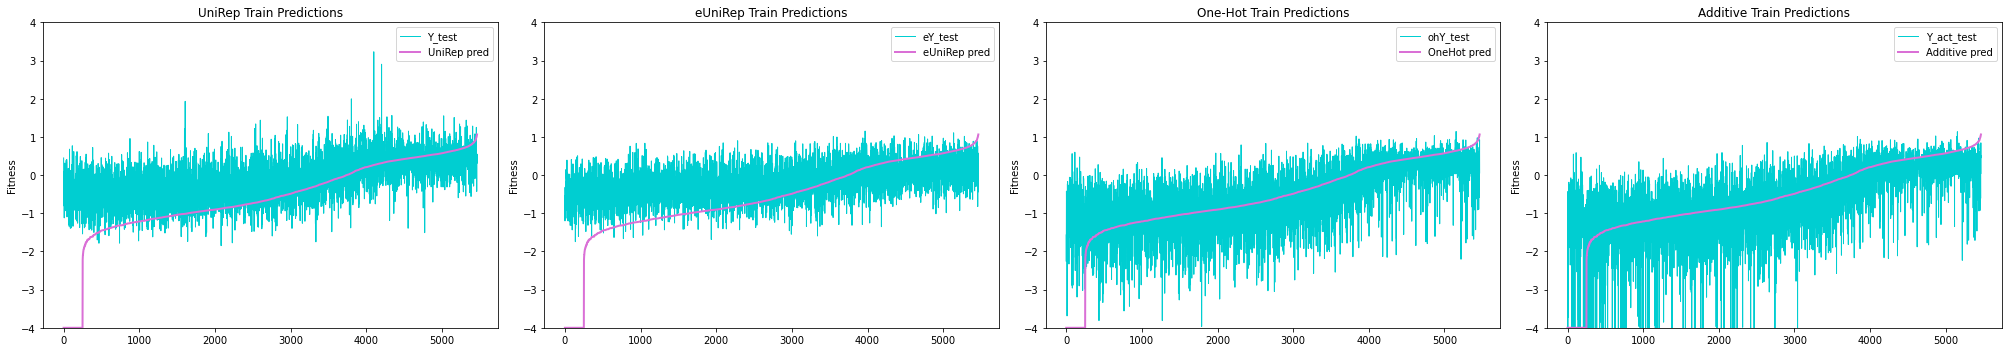

In [12]:
plt.clf()

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(28,5))

ax[0].plot(np.arange(len(Y_test)), np.array(Y_test_preds)[np.argsort(Y_test)],color="darkturquoise",linewidth=1)
ax[0].plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color="orchid",linewidth=2)
ax[0].legend(['Y_test','UniRep pred'])
ax[0].set_ylim(-4,4)
ax[0].set_ylabel("Fitness")
ax[0].set_title("UniRep Train Predictions")


ax[1].plot(np.arange(len(Y_test)), np.array(eY_test_preds)[np.argsort(Y_test)],color="darkturquoise",linewidth=1)
ax[1].plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color="orchid",linewidth=2)
ax[1].legend(['eY_test','eUniRep pred'])
ax[1].set_ylim(-4,4)
ax[1].set_ylabel("Fitness")
ax[1].set_title("eUniRep Train Predictions")


ax[2].plot(np.arange(len(Y_test)), np.array(ohY_test_preds)[np.argsort(Y_test)],color="darkturquoise",linewidth=1)
ax[2].plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color="orchid",linewidth=2)
ax[2].legend(['ohY_test','OneHot pred'])
ax[2].set_ylim(-4,4)
ax[2].set_ylabel("Fitness")
ax[2].set_title("One-Hot Train Predictions")


ax[3].plot(np.arange(len(Y_test)), np.array(Y_additive)[np.argsort(Y_test)],color="darkturquoise",linewidth=1)
ax[3].plot(np.arange(len(Y_test)), np.array(Y_test)[np.argsort(Y_test)],color="orchid",linewidth=2)
ax[3].legend(['Y_act_test','Additive pred'])
ax[3].set_ylim(-4,4)
ax[3].set_ylabel("Fitness")
ax[3].set_title("Additive Train Predictions")

plt.tight_layout()
plt.show()

### Organize Measured and predicted data into grid-dataframes based on positions and amino acid identity

In [0]:

double_mut_data = {}

data_labels = ["measured", "UniRep","eUniRep","OneHot","additive"]
mut_pos_combos = ["7172","7173","7174","7175","7176","7273","7274","7275","7276","7374","7375","7376","7475","7476","7576"]

for label in data_labels:
  double_mut_data[label] = {}
  for mut_pos in mut_pos_combos:
    double_mut_data[label][mut_pos] = get_empty_aa_grid()

for aa1,loc1,aa2,loc2,index in zip(double_mut_AAs_1,double_mut_locs_1,double_mut_AAs_2,double_mut_locs_2,np.arange(len(double_mut_AAs_1))):
  double_mut_data["measured"][str(loc1+1)+str(loc2+1)].loc[str(aa1),str(aa2)] = pred_dict['measured'][index]
  double_mut_data["UniRep"][str(loc1+1)+str(loc2+1)].loc[str(aa1),str(aa2)] = pred_dict['UniRep'][index]
  double_mut_data["eUniRep"][str(loc1+1)+str(loc2+1)].loc[str(aa1),str(aa2)] = pred_dict['eUniRep'][index]
  double_mut_data["OneHot"][str(loc1+1)+str(loc2+1)].loc[str(aa1),str(aa2)] = pred_dict['OneHot'][index]
  double_mut_data["additive"][str(loc1+1)+str(loc2+1)].loc[str(aa1),str(aa2)] = pred_dict['additive'][index]


#### Plot heatmaps for measured and predicted data, for all position combos

<Figure size 432x288 with 0 Axes>

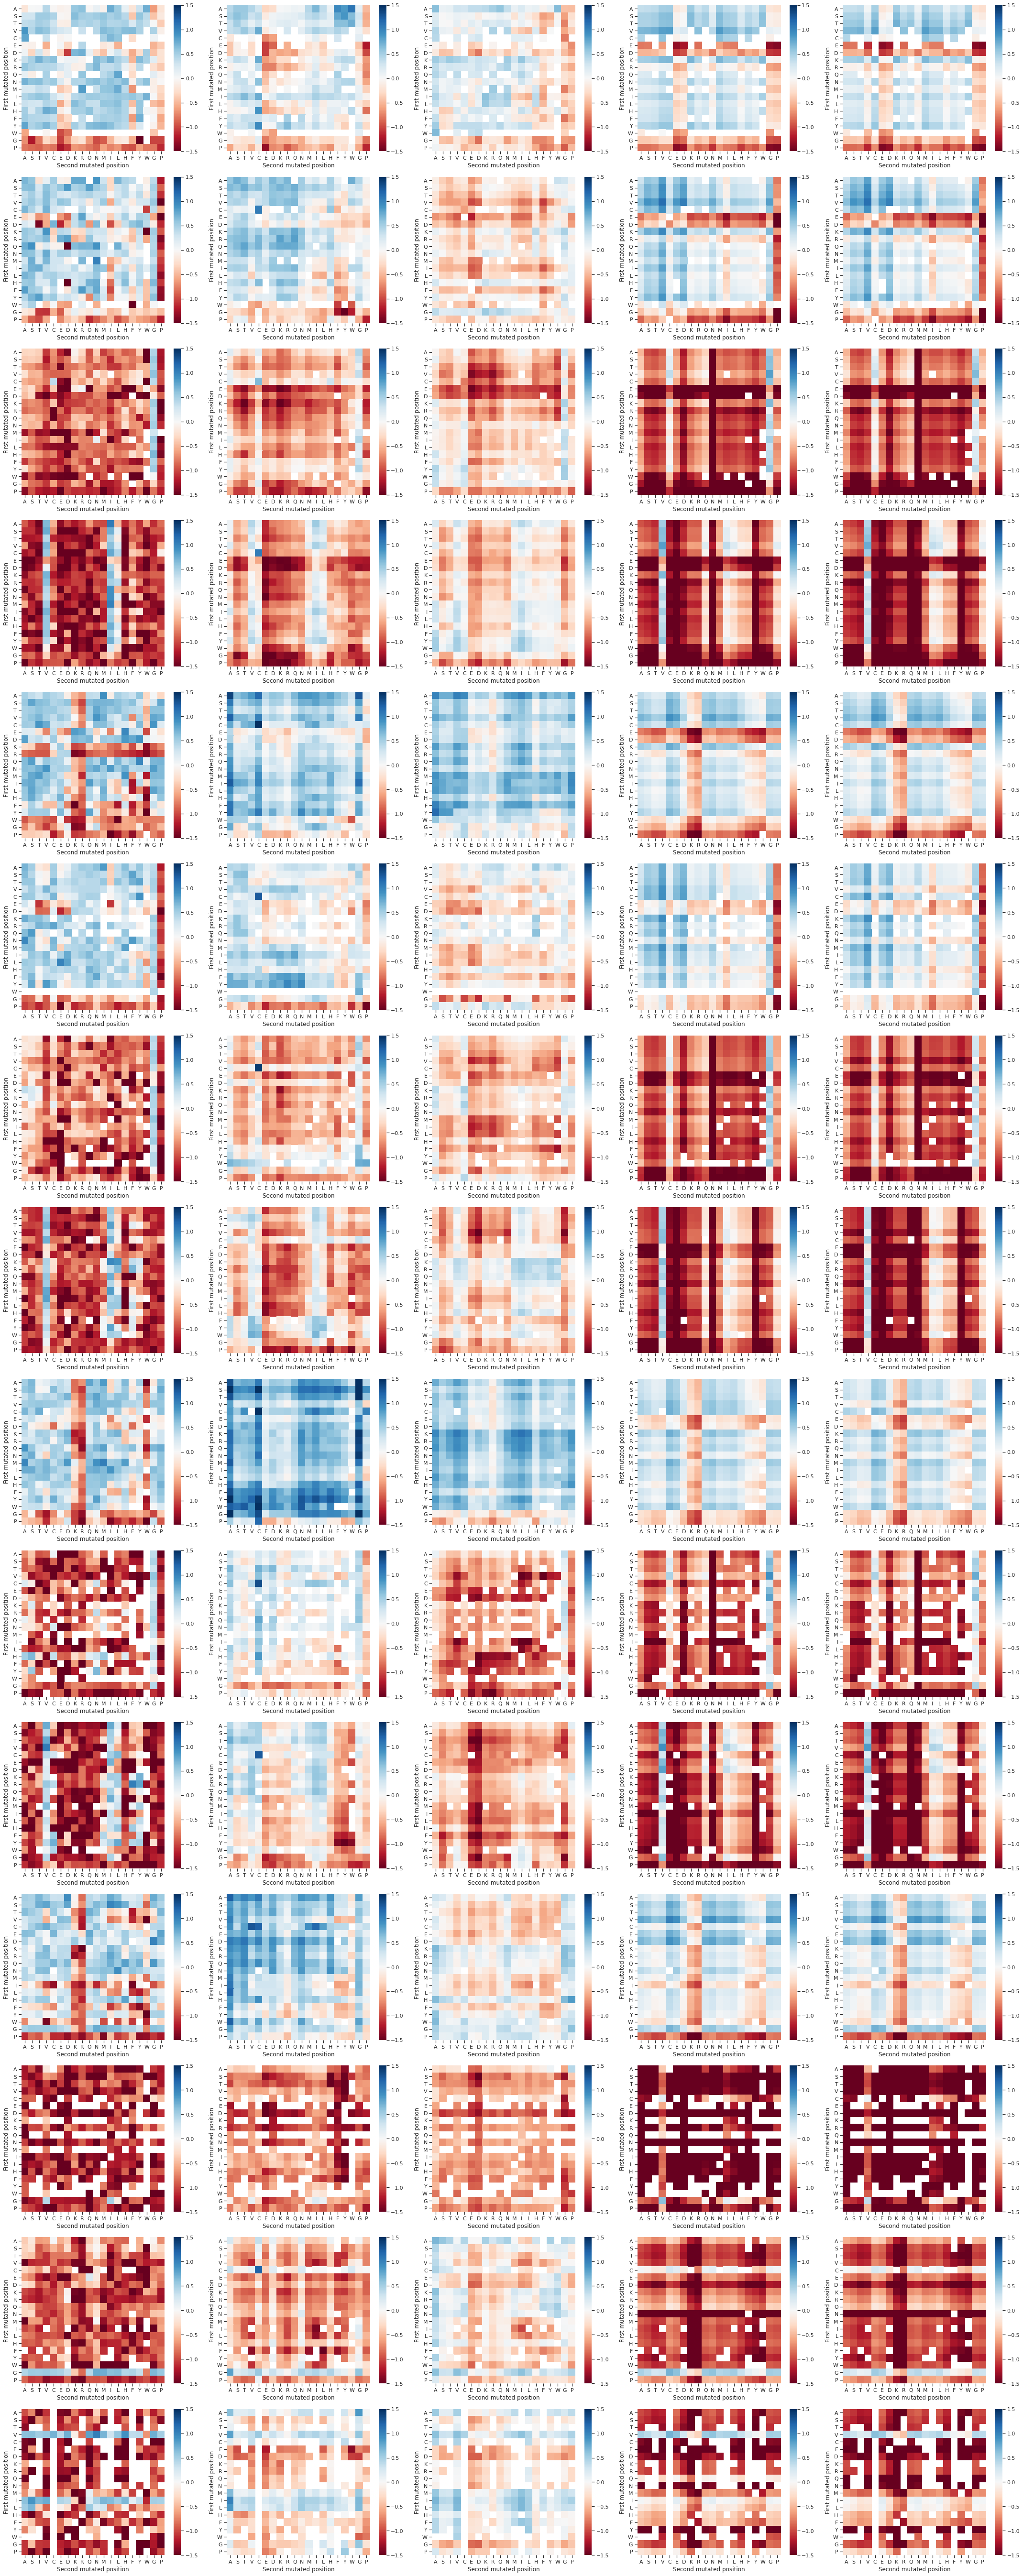

In [14]:
plt.clf()
sns.set(style="ticks")
aa_df_labels = ['A','S','T','V','C','E','D','K','R','Q','N','M','I','L','H','F','Y','W','G','P']

cmap = 'RdBu'

fig, axes = plt.subplots(nrows=len(mut_pos_combos), ncols=len(data_labels), figsize=(6*len(data_labels),5*len(mut_pos_combos)))

for i in range(len(mut_pos_combos)):
  mut_positions = mut_pos_combos[i]
  for j in range(len(data_labels)):
    condition = data_labels[j]
    sns.heatmap(double_mut_data[condition][mut_positions].astype('float'), 
                cmap=cmap, mask=double_mut_data[condition][mut_positions].astype('float').isnull(),
                vmin=-1.5, vmax=1.5,
                ax=axes[i,j],
                xticklabels=aa_df_labels, 
                yticklabels=aa_df_labels)

    axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), rotation = 0)
    axes[i,j].set_yticklabels(axes[i,j].get_yticklabels(), rotation = 0)

    axes[i,j].set_ylabel("First mutated position")
    axes[i,j].set_xlabel("Second mutated position")

plt.tight_layout()
plt.show()